# Building Shallow Neural Network using just NumPy

Building a Neural Network classifier from **first principles**: 
* Create model architecture and initialize parameters
* Calculating Cost Function and its Gradients
* Optimizing using gradient descent

---
## Neural Network architecture

<img src="images/classification_kiank.png" style="width:600px;height:300px;">

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

---
## Loading data
* a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
* a test set of m_test images labeled as cat or non-cat
* each image is of shape (64, 64, 3) where 3 is for the 3 channels (RGB)

In [2]:
train = h5py.File('data/train_catvnoncat.h5', "r")
X_train_orig = np.array(train["train_set_x"][:])
Y_train = np.array(train["train_set_y"][:])

test = h5py.File('data/test_catvnoncat.h5', "r")
X_test_orig = np.array(test["test_set_x"][:]) 
Y_test = np.array(test["test_set_y"][:])
classes = np.array(test["list_classes"][:])

Y_train = Y_train.reshape((1, Y_train.shape[0]))
Y_test  = Y_test.reshape((1, Y_test.shape[0]))

X_train = X_train_orig.reshape(X_train_orig.shape[0],-1).T
X_test  = X_test_orig.reshape(X_test_orig.shape[0],-1).T

X_train = X_train / 255.
X_test = X_test / 255.

print ("X_train shape: " + str(X_train.shape))
print ("X_test shape: " + str(X_test.shape))

X_train shape: (12288, 209)
X_test shape: (12288, 50)


y = [1], it's a 'cat' picture.


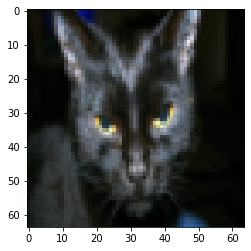

In [3]:
# Example of a picture
index = 25
plt.imshow(X_train_orig[index])
print ("y = " + str(Y_train[:, index]) + ", it's a '" + classes[np.squeeze(Y_train[:, index])].decode("utf-8") +  "' picture.")

## Helper Functions
---

### Sigmoid

In [4]:
def sigmoid(z):
    """
    Compute the sigmoid of z (scalar or numpy array of any size.)
    """
    return 1/(1+np.exp(-z))

### Initialize Parameters

In [5]:
def initialize_parameters(n_x, n_h, n_y):
    """
    n_x, n_h, n_y -- size of the input / hidden / output layer
    """    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### Forward + Backward Propagation
**Forward Propagation:**
$$Z^{[1]} =  W^{[1]} X + b^{[1]}$$ 
$$A^{[1]} = \tanh(Z^{[1]})$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$\hat{Y} = A^{[2]} = \sigma(Z^{[2]})$$

**Cost:**
$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small$$

**Backward Propagation:**
<img src="images/NN_equations.png" style="width:400px;height:300px;">

$g^{[1]'}(Z^{[1]}) = 1 - A^2$ since $g^{[1]}(.)$ is the tanh activation function

In [6]:
def forward_propagation(X, parameters):
    """
    Compute forward propagation step
    """
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = np.dot(W1,X) + b1  # we can think of X as A0
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
      
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1, "A1": A1,
             "Z2": Z2, "A2": A2}
    
    return A2, cache

In [7]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost    
    """
    m = Y.shape[1] # number of examples
    cost = (-1/m)*(np.dot(np.log(A2), Y.T) + np.dot(np.log(1-A2), (1-Y).T))    
    cost = float(np.squeeze(cost))  # E.g., turns [[17]] into 17 
    return cost

In [8]:
def backward_propagation(parameters, cache, X, Y):
    """
    Compute gradients
    """
    m = X.shape[1]
    W1 = parameters['W1']
    W2 = parameters['W2']    
    A1 = cache['A1']
    A2 = cache['A2']

    dZ2 = A2 - Y
    dW2 = (1/m)*np.dot(dZ2, A1.T)
    db2 = (1/m)*np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1- A1**2)             # W2 & dZ2 is used here
    dW1 = (1/m)*np.dot(dZ1, X.T)
    db1 = (1/m)*np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1, "db1": db1,
             "dW2": dW2, "db2": db2} # dZ is not needed, as it is not a parameter
    
    return grads

### Optimize

In [9]:
def update_parameters(parameters, grads, learning_rate=0.01):
    """
    Updates parameters using the gradient descent
    """
    W1 = copy.deepcopy(parameters['W1'])
    b1 = parameters['b1']
    W2 = copy.deepcopy(parameters['W2'])
    b2 = parameters['b2']     

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']    

    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    
    parameters = {"W1": W1, "b1": b1,
                  "W2": W2, "b2": b2}
    
    return parameters

### Predict

In [10]:
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)
    return predictions

### Combining into an Overall Model

In [11]:
def nn_model(X_train, Y_train, X_test, Y_test, n_h, num_iterations = 10000, print_cost=False, learning_rate=1.2):
    """
    n_h -- size of the hidden layer
    """
    costs = []
    n_x = X_train.shape[0]
    n_y = Y_train.shape[0]
    np.random.seed(3)
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X_train, parameters)  # Forward pass
        grads = backward_propagation(parameters, cache, X_train, Y_train)  # Backward pass
        parameters = update_parameters(parameters, grads, learning_rate)  # Update params
        cost = compute_cost(A2, Y_train)  # Compute cost
        
        if print_cost and i % 100 == 0:
            print ('Cost after iteration {}: {:.4f}'.format(i, cost))
            costs.append(cost)

    # Make Predictions
    Y_pred_train = predict(parameters, X_train)
    Y_pred_test = predict(parameters, X_test)
    
    # Print train/test fit
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_pred_train": Y_pred_train, 
         "Y_pred_test" : Y_pred_test, 
         "parameters" : parameters,
         "learning_rate" : learning_rate}
    
    return d

---
## Running Model

In [12]:
n_h = 25
model = nn_model(X_train, Y_train, X_test, Y_test, n_h, num_iterations = 2000, print_cost=True, learning_rate=0.01)

Cost after iteration 0: 0.6922
Cost after iteration 100: 0.6433
Cost after iteration 200: 0.6262
Cost after iteration 300: 0.5816
Cost after iteration 400: 0.5126
Cost after iteration 500: 0.4333
Cost after iteration 600: 0.3534
Cost after iteration 700: 0.3831
Cost after iteration 800: 0.3224
Cost after iteration 900: 0.2739
Cost after iteration 1000: 0.2287
Cost after iteration 1100: 0.1839
Cost after iteration 1200: 0.1397
Cost after iteration 1300: 0.1061
Cost after iteration 1400: 0.0827
Cost after iteration 1500: 0.0690
Cost after iteration 1600: 0.0590
Cost after iteration 1700: 0.0510
Cost after iteration 1800: 0.0446
Cost after iteration 1900: 0.0393
train accuracy: 100.0 %
test accuracy: 72.0 %


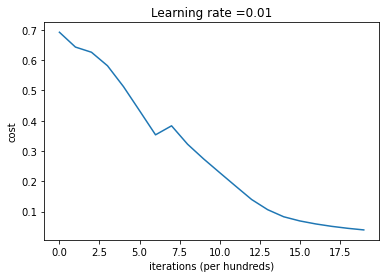

In [13]:
# Plot learning curve (with costs)
costs = np.squeeze(model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(model["learning_rate"]))
plt.show()

## Conclusion
Neural Network learns faster and performs better than logistic regression model built previously. However, at present, it overfits the Training data (accuracy of ~100%) with Test accuracy of only ~72%. However, the main takeaway here is building the **Neural Network model from first principles, without using any library.**

y = 1, prediction is "non-cat" picture.


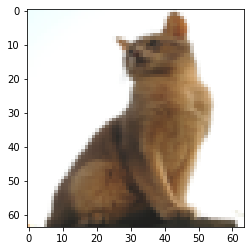

In [14]:
# Example of a wrong classification
index = 6
plt.imshow(X_test[:, index].reshape((64,64,3)))
print ("y = " + str(Y_test[0,index]) + ", prediction is \"" + classes[int(model['Y_pred_test'][0,index])].decode("utf-8") +  "\" picture.")

y = 1, prediction is "cat" picture.


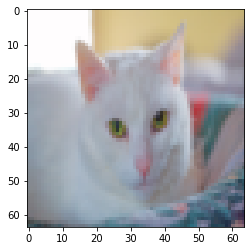

In [15]:
# Example of a correct classification
index = 2
plt.imshow(X_test[:, index].reshape((64,64,3)))
print ("y = " + str(Y_test[0,index]) + ", prediction is \"" + classes[int(model['Y_pred_test'][0,index])].decode("utf-8") +  "\" picture.")